# TST (Time Series Transformer) 🤗

## TST *args* and *kwargs*

通常的值出现在“Attention is all you need”和“A Transformer-based Framework for Multivariate Time Series Representation Learning”论文中。

默认值是在后者中选择作为默认配置的值。

* c_in：时间序列数据集中的特征（又名变量、维度、通道）数量。 dls.var
* c_out：目标类的数量。 dls.c
* seq_len：时间序列中的时间步数。 dls.len
* max_seq_len：用于控制长时间序列的时间分辨率以避免内存问题。 默认。 没有任何。
* d_model：模型的总维度（模型创建的特征数量）。 通常值：128-1024。 默认值：128。
* n_heads：并行注意力头。 通常值：8-16。 默认值：16。
* d_k：MHA 中查询和键的学习线性投影的大小。 通常值：16-512。 默认值：无 -> (d_model/n_heads) = 32。
* d_v：MHA 中学习到的值的线性投影的大小。 通常值：16-512。 默认值：无 -> (d_model/n_heads) = 32。
* d_ff：前馈网络模型的维度。 通常值：256-4096。 默认值：256。
* dropout：编码器中应用的残余dropout量。 通常值：0.-0.3。 默认值：0.1。
* 激活：中间层的激活函数，relu或gelu。 默认值：'gelu'。
* num_layers：编码器中子编码器层的数量。 通常值：2-8。 默认值：3。
* fc_dropout：应用于最终全连接层的dropout。 通常值：0-0.8。 默认值：0。
* pe：位置编码器类型。 可用类型：无、“gauss”（默认）、“lin1d”、“exp1d”、“2d”、“sincos”、“zeros”。 默认值：“高斯”。
* learn_pe：学习位置编码器（True，默认）或固定位置编码器。 默认值：真。
* 展平：这将使编码器输出展平，以便能够应用 mlp 类型的头。 默认=真。
* custom_head：将应用于网络的自定义头。 它必须包含所有 kwargs（传递部分函数）。 默认值：无。
* y_range：可能的 y 值范围（用于回归任务）。 默认值：无
* kwargs：nn.Conv1d kwargs。 如果不是 {}，则具有这些 kwargs 的 nn.Conv1d 将应用于原始时间序列。

## Tips on how to use transformers:

* 一般来说，当与相同的数据集一起使用时，与其他时间序列模型相比，transformer需要更低的 lr。 使用learn.lr_find()来了解什么是好的lr很重要。

* 论文作者建议按特征对数据进行标准化。 这可以通过在创建“TSDataLoaders”时添加“TSStandardize(by_var=True”作为batch_tfm)来完成。

* 当使用 TST 处理较长时间序列时，您可以使用 `max_w_len` 来减少内存大小，从而避免 GPU 问题。

* 我尝试过不同类型的位置编码器。 根据我的经验，默认的效果就很好。

* 在我使用过的某些情况下，您可能需要增加 dropout > .1 和/或 fc_dropout > 0 以获得良好的性能。

* 您还可以尝试其他关键超参数，如 d_model、n_layers、n_heads 等，但我在我的经验中没有看到重大差异。

# Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
!pip install tsai

In [ ]:
from tsai.all import *
computer_setup()

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.33
torch           : 2.2.1+cu121
device          : 1 gpu (['Tesla T4'])
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : [15.0] GB


# Load data 🔢

>**我的数据**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file
df = pd.read_csv('/content/dataset_update3_bkup.csv')

# Convert the 'dataset' column to numpy arrays
df['dataset'] = df['dataset'].apply(lambda x: np.array(eval(x)))

# Convert DataFrame to numpy arrays
data = np.stack(df['dataset'].values)

# Reshape the data to a three-dimensional array
data = data.reshape(data.shape[0], 1, data.shape[1])

# Extract labels
labels = df['label'].values

print(data.shape,labels.shape)

(1379, 1, 51) (1379,)


In [ ]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

# InceptionTime ⎘

为了进行比较，我将使用最先进的时间序列模型作为起始时间。

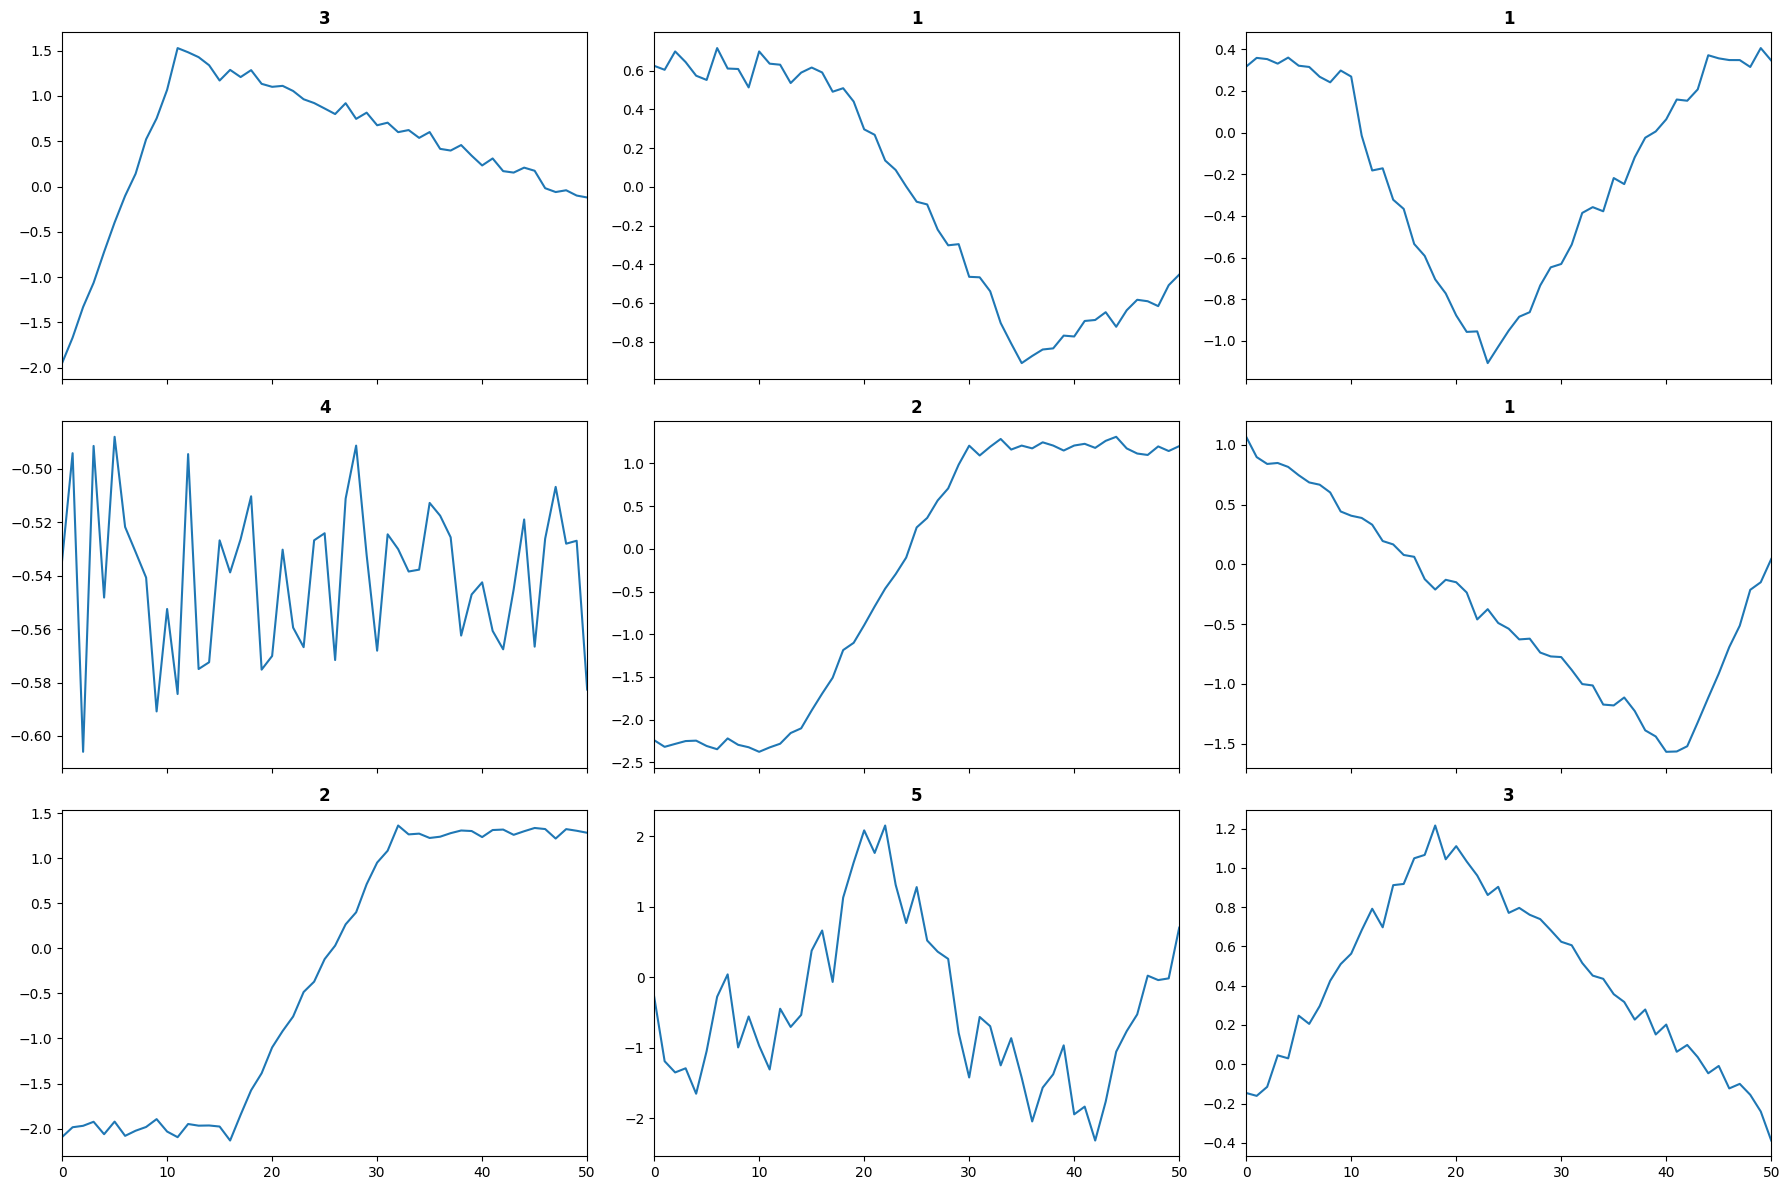

In [ ]:
bs = 16
n_epochs = 50
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())
dls.show_batch()

SuggestedLRs(valley=0.0004786300996784121)

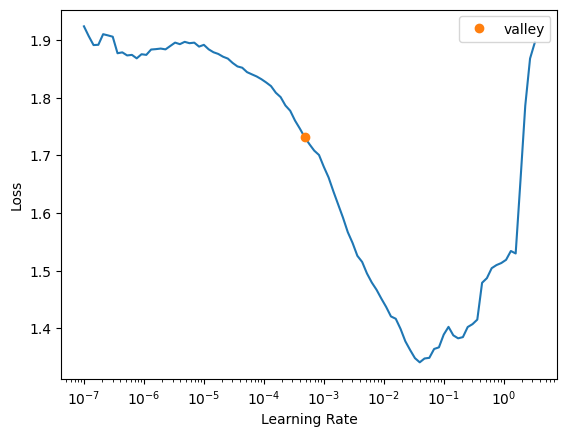

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.304093,0.960859,0.771739,00:01
1,0.868500,0.456350,0.865942,00:01
2,0.603494,0.320544,0.905797,00:01
3,0.499631,0.358929,0.873188,00:01
4,0.385996,0.251124,0.945652,00:01
5,0.338745,0.234100,0.916667,00:01
6,0.283703,0.192017,0.934783,00:01
7,0.279171,0.220519,0.923913,00:01
8,0.255918,0.110193,0.967391,00:01
9,0.236806,0.143194,0.971014,00:01


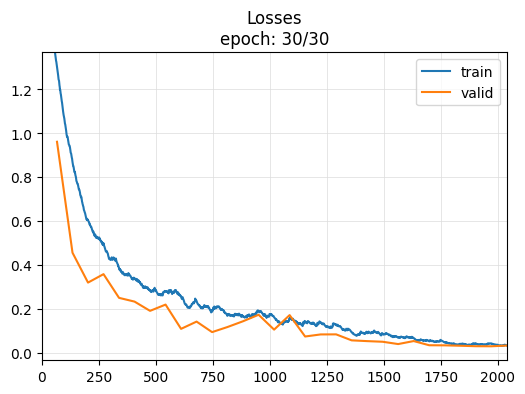

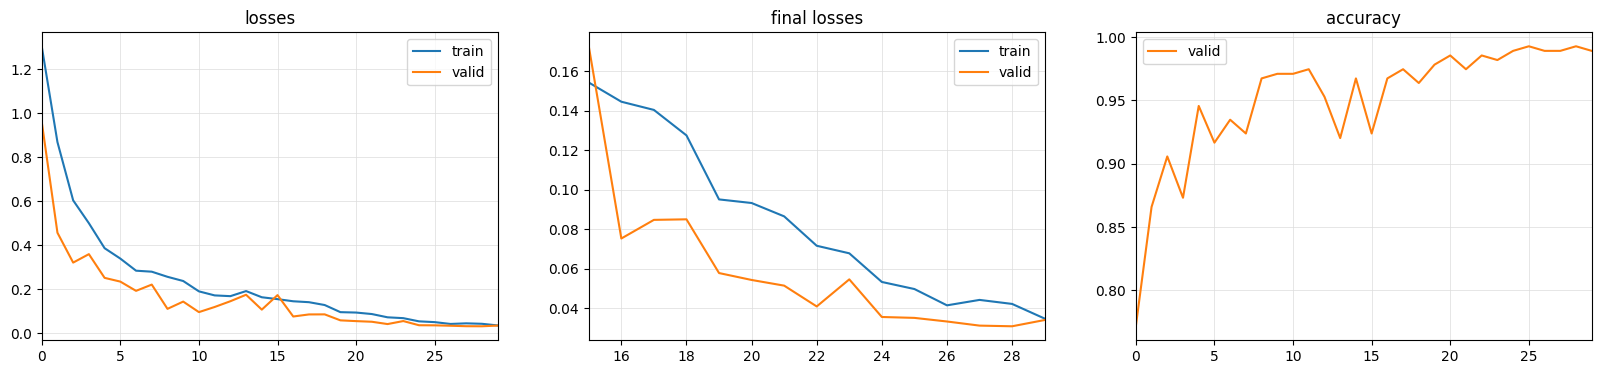


Elapsed time: 53.146666288375854


In [ ]:
start = time.time()
# n_epochs = 20
learn.fit_one_cycle(30, lr_max=1e-3)
print('\nElapsed time:', time.time() - start)

In [ ]:
learn.save('incptiontime_stage1')
# learn.recorder.plot_metrics()
learn.save_all(path='export', dls_fname='dataset_update3_bkup_inceptiontime_30epochs_dls',
               model_fname='dataset_update3_bkup_inceptiontime_30epochs_model', learner_fname='dataset_update3_bkup_inceptiontime_30epochs_learner')

In [ ]:
learn = load_learner_all(path='export', dls_fname='dataset_update3_bkup_inceptiontime_30epochs_dls',
               model_fname='dataset_update3_bkup_inceptiontime_30epochs_model', learner_fname='dataset_update3_bkup_inceptiontime_30epochs_learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
(valid_targets == valid_preds).float().mean()

tensor(0.9891)

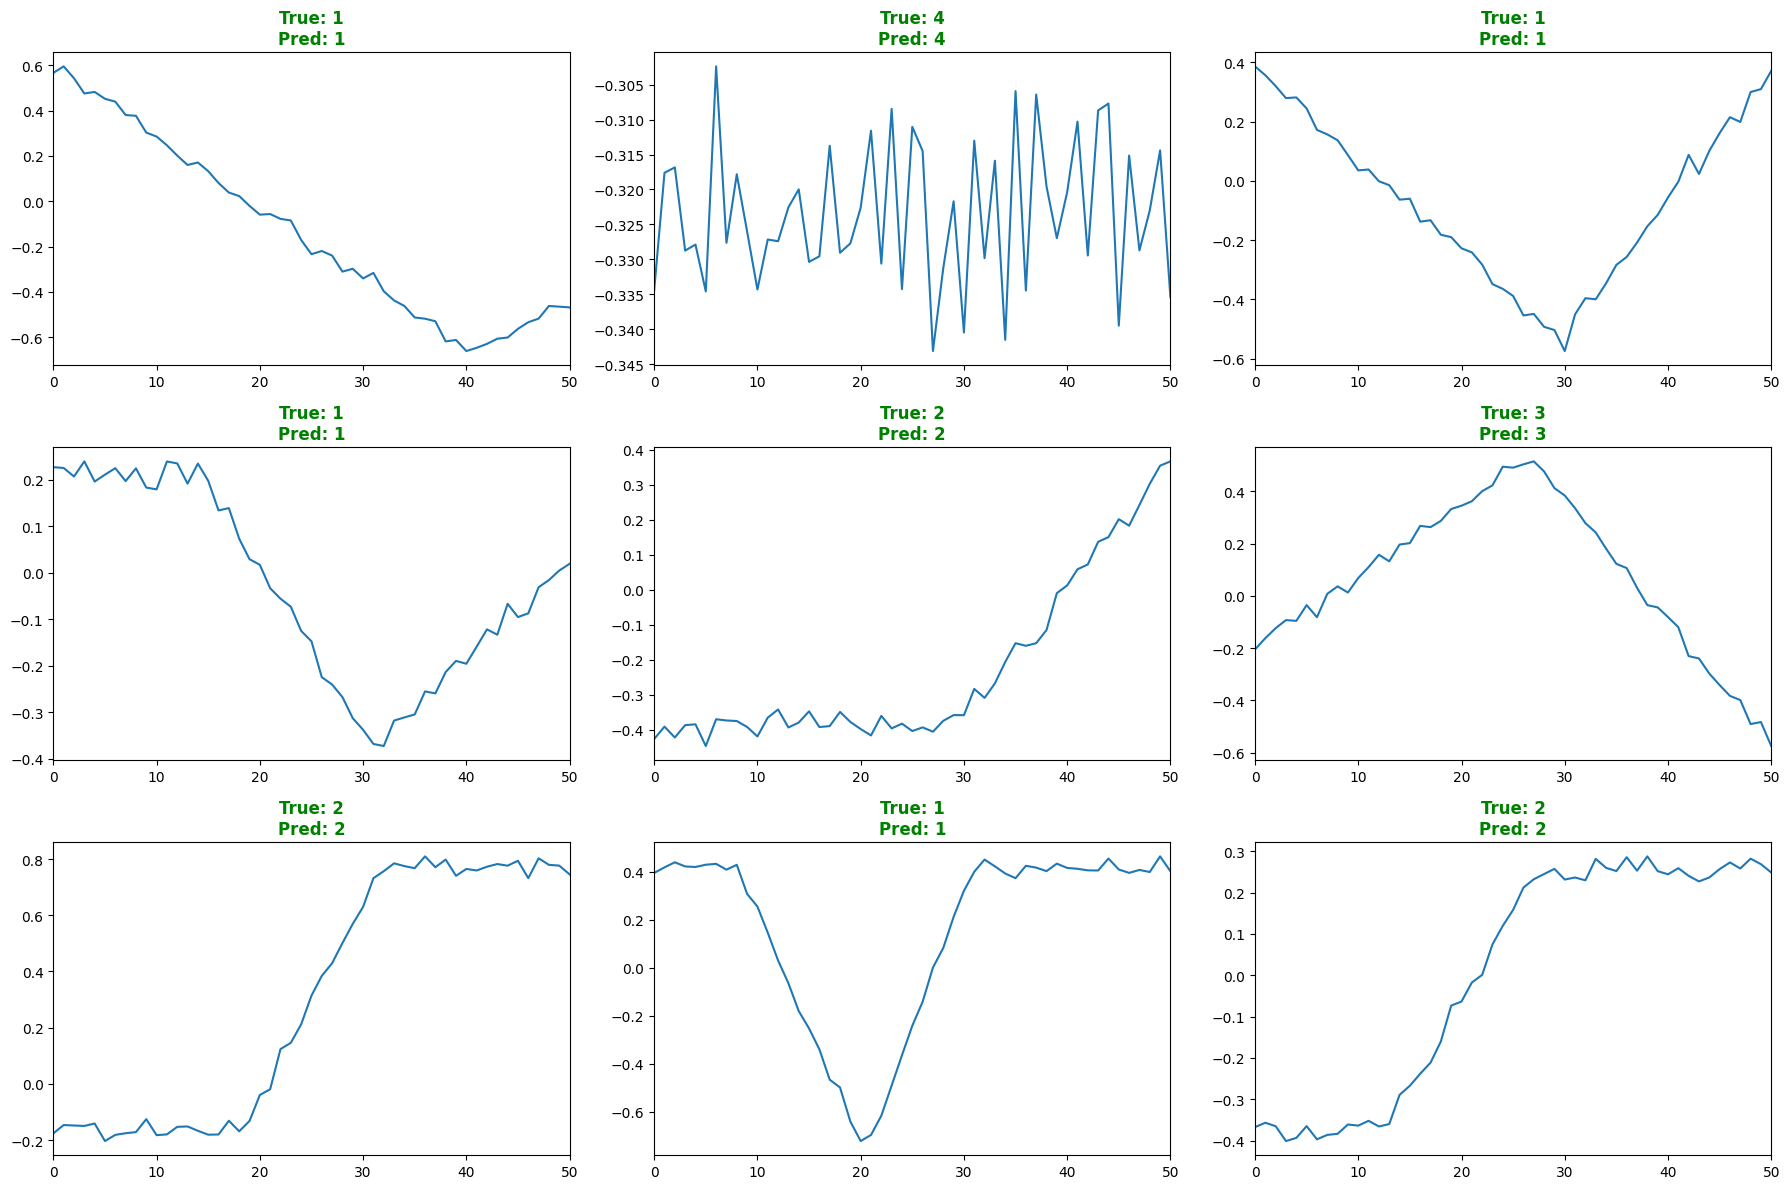

In [ ]:
learn.show_results()

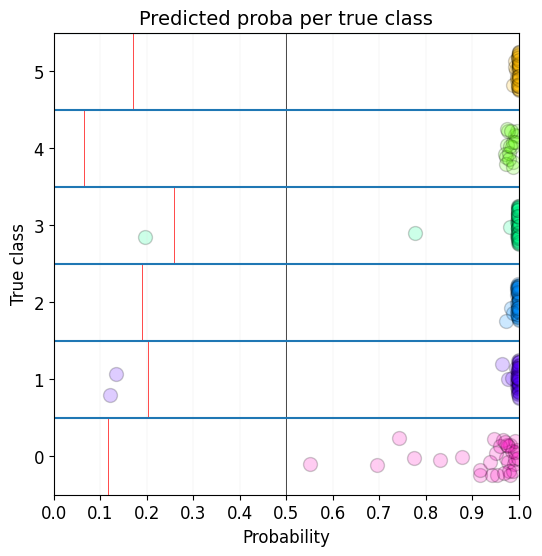

In [ ]:
learn.show_probas()

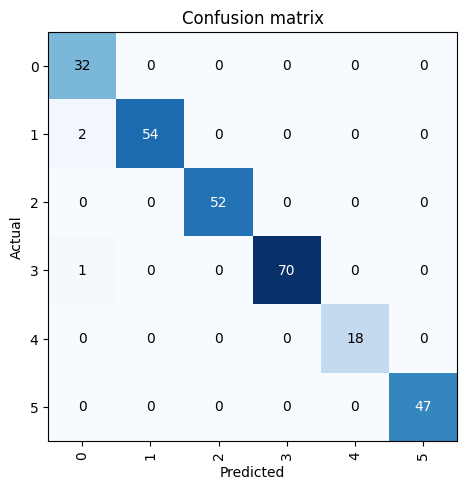

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=3)

[]

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(X, y)# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:16, vars:1, len:51, device=cuda:0, dtype=torch.float32),
 TensorCategory([4, 1, 3, 2, 5, 1, 1, 3, 2, 5, 1, 5, 0, 5, 3, 0],
                device='cuda:0'))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.3471e-04, 3.4840e-05, 1.0447e-02, 1.2426e-04, 9.8876e-01, 1.3724e-06],
         [8.3128e-04, 9.9880e-01, 5.4251e-05, 9.2371e-05, 1.8814e-04, 3.0128e-05],
         [2.9235e-04, 9.5441e-04, 5.8161e-04, 9.9788e-01, 1.6738e-04, 1.2885e-04],
         ...,
         [2.9730e-05, 9.9995e-01, 1.3930e-05, 1.3248e-06, 1.9021e-06, 2.9245e-06],
         [1.0341e-03, 8.8693e-04, 2.1852e-01, 7.7578e-01, 2.6725e-03, 1.1123e-03],
         [1.6628e-02, 1.2017e-04, 4.8272e-04, 2.5649e-04, 9.8251e-01, 9.9235e-07]]),
 tensor([4, 1, 3,  ..., 1, 3, 4]),
 tensor([4, 1, 3,  ..., 1, 3, 4]))

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.992023


In [ ]:
!pip install rasterio

In [ ]:
import rasterio
# Load the .tif image
with rasterio.open("/content/slc_ndvi_fit_1972_2022.tif") as src:
    image_data = src.read()
    row = image_data.shape[1]
    column = image_data.shape[2]
    # Reshape to (rows, columns, bands)
    image_data = np.transpose(image_data, (1, 2, 0))

print('transposed shape:', image_data.shape)

# Reshape the image data to (rows * columns, bands)
img_data = image_data.reshape(-1,image_data.shape[2])/1000
print('reshaped shape:', img_data.shape)
print(img_data[0][:])

transposed shape: (628, 620, 51)
reshaped shape: (389360, 51)
[0.67  0.645 0.621 0.597 0.573 0.575 0.577 0.579 0.581 0.583 0.586 0.588
 0.59  0.592 0.594 0.596 0.598 0.6   0.603 0.605 0.607 0.609 0.611 0.613
 0.615 0.618 0.62  0.622 0.624 0.626 0.628 0.63  0.633 0.635 0.637 0.639
 0.641 0.643 0.645 0.647 0.65  0.652 0.654 0.656 0.658 0.66  0.662 0.665
 0.667 0.669 0.671]


In [ ]:
ts_data = to3d(img_data)

print(ts_data.shape)

(389360, 1, 51)


In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(ts_data)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:16, vars:1, len:51, device=cuda:0, dtype=torch.float32),)

In [ ]:
test_probas, test_preds, test_decoded = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None)
test_preds,test_decoded

(None, tensor([4, 4, 4,  ..., 3, 4, 4]))

In [ ]:
classified = test_decoded.reshape(row,column)
print('classified shape:',classified.shape)
print('begin saving classified image....')
# Save the classified image
with rasterio.open('/content/slc_ndvi_inceptiontime_cls.tif', 'w', driver='GTiff',
                   height=row, width=column, count=1, dtype=rasterio.int8, crs=src.crs, transform=src.transform,
                   nodata=src.nodata, compress='lzw'
                   ) as dst:
    dst.write(classified, 1)
print('Done')

classified shape: torch.Size([628, 620])
begin saving classified image....
Done


# TST baseline 🧢

1 6 51


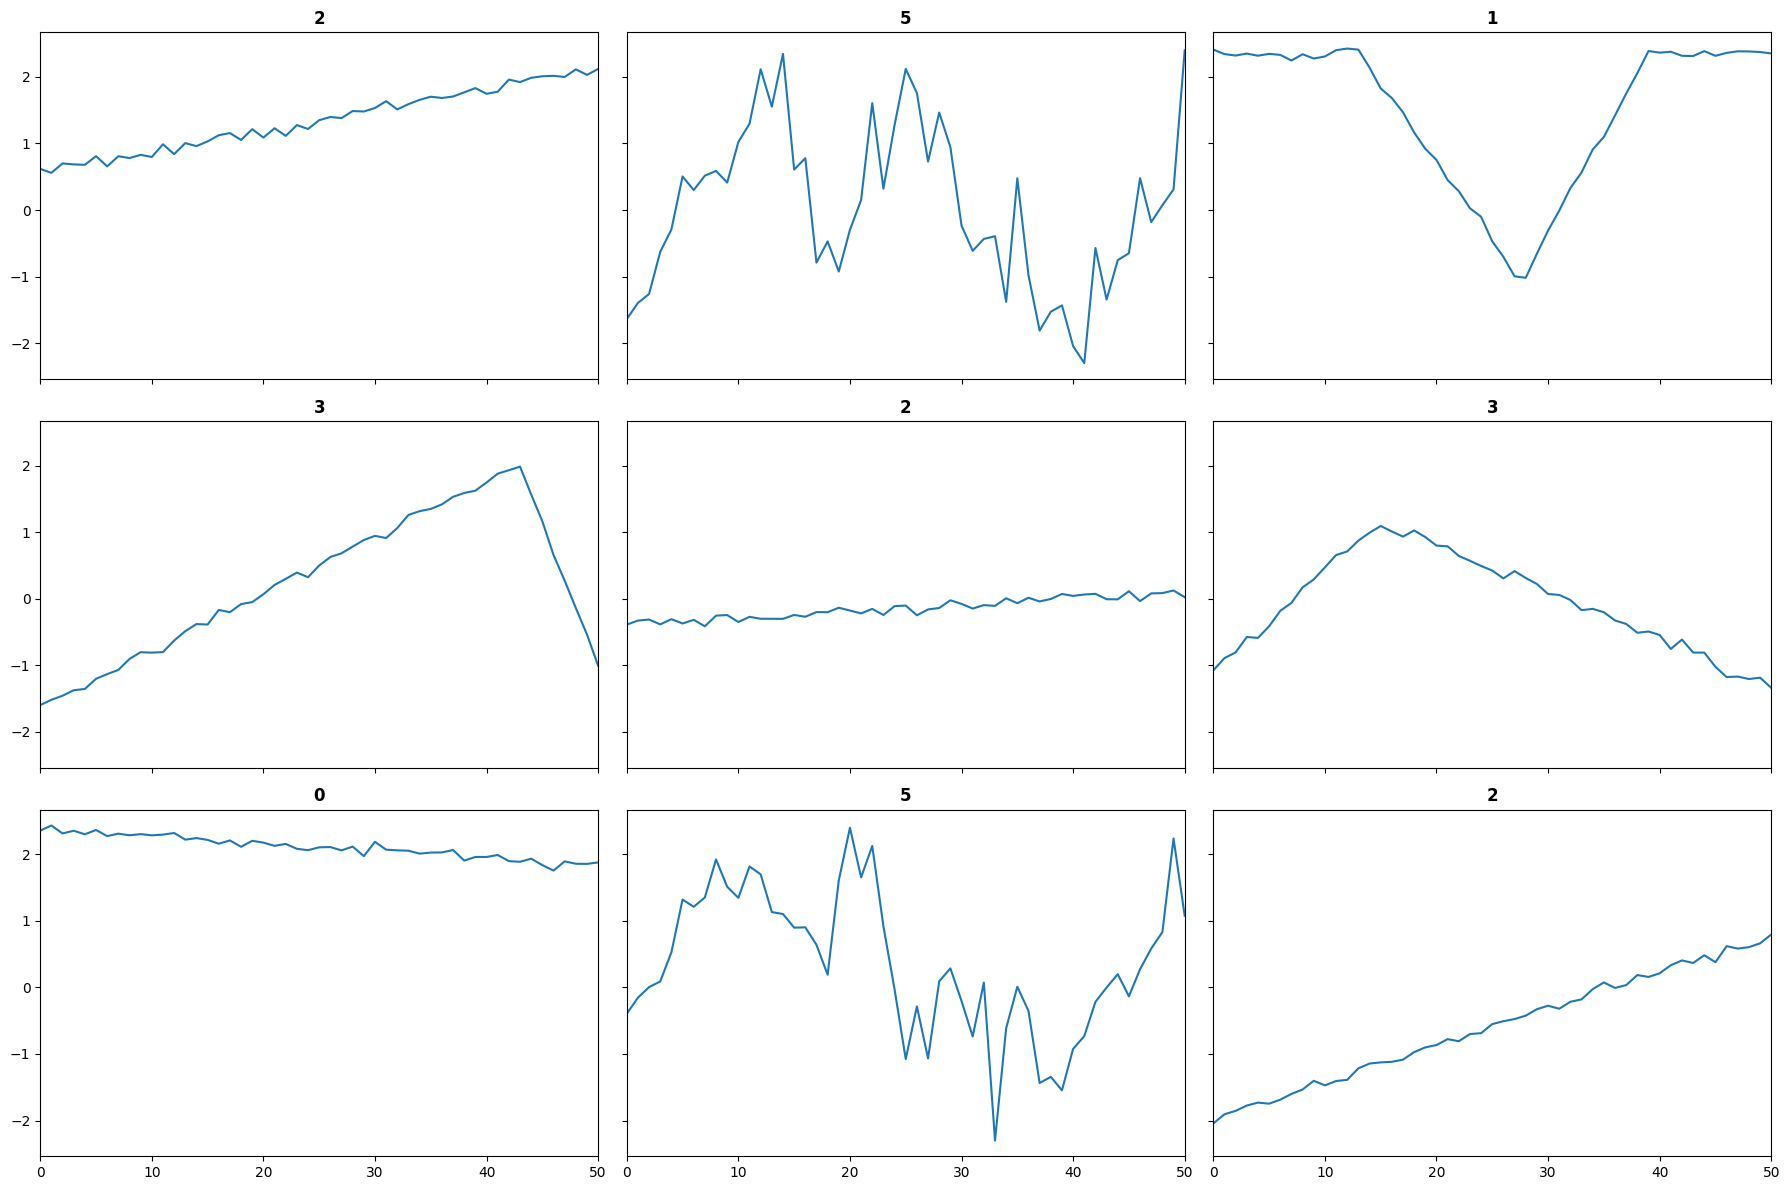

In [ ]:
bs = 16
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize(by_var=True),num_workers=0)
print(dls.vars, dls.c, dls.len)
dls.show_batch(sharey=True)

SuggestedLRs(valley=0.0002290867705596611)

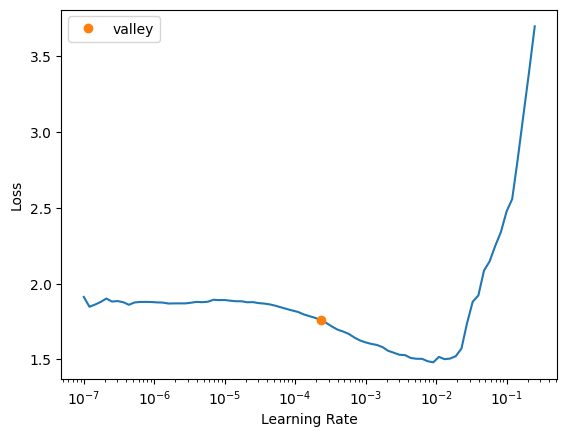

In [ ]:
model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.519475,1.288516,0.648551,00:01
1,1.169691,0.947800,0.800725,00:01
2,0.929242,0.757723,0.858696,00:01
3,0.771443,0.665607,0.902174,00:01
4,0.683599,0.606189,0.949275,00:01
5,0.632848,0.571153,0.967391,00:01
6,0.594248,0.557530,0.967391,00:01
7,0.567667,0.538098,0.978261,00:01
8,0.553562,0.520133,0.978261,00:01
9,0.545911,0.553649,0.974638,00:01


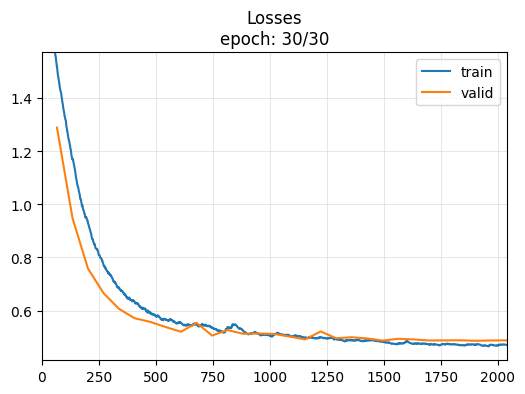

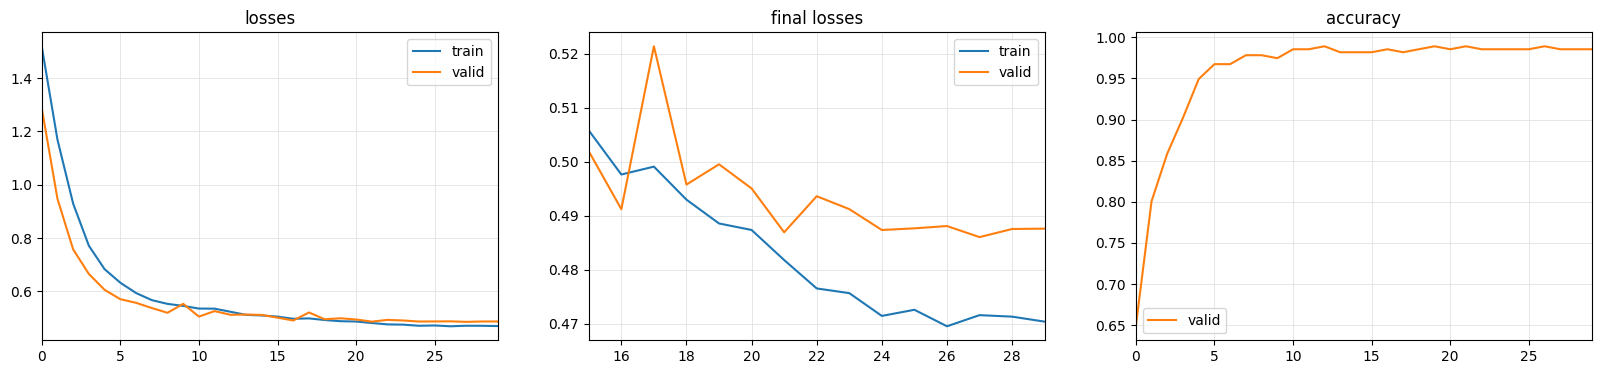


Elapsed time: 54.97301483154297


In [ ]:
n_epoch = 30
model = TST(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy,  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(n_epoch, lr_max=3e-4)
print('\nElapsed time:', time.time() - start)

# How to improve performance with TST? ➕

为了尝试提高性能，我将增加 dropout。 TST 有 2 种类型的 dropout：

* 应用于 MHAttention 和 Feed-Forward 层。 通常为0-0.3。 默认值：0.1。

* 适用于全连接。 通常为0-0.8。 默认值：0。

让我们看看这两个超参数单独使用和组合使用有何影响。

epoch,train_loss,valid_loss,accuracy,time
0,1.556138,1.411856,0.619565,00:01
1,1.290393,1.079349,0.750000,00:01
2,1.042460,0.836440,0.862319,00:01
3,0.871982,0.733702,0.898551,00:01
4,0.767284,0.652214,0.949275,00:01
5,0.699689,0.608345,0.942029,00:01
6,0.647761,0.581452,0.960145,00:01
7,0.625903,0.597348,0.945652,00:01
8,0.610899,0.573716,0.960145,00:01
9,0.596721,0.554632,0.974638,00:01


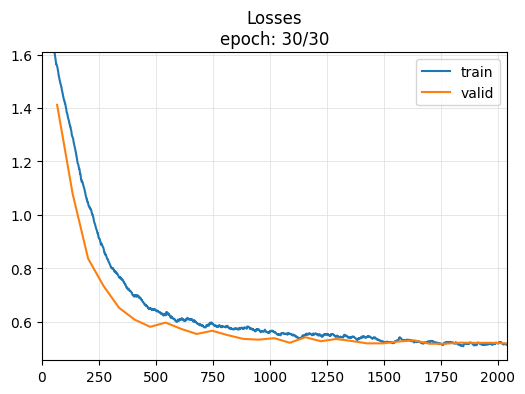

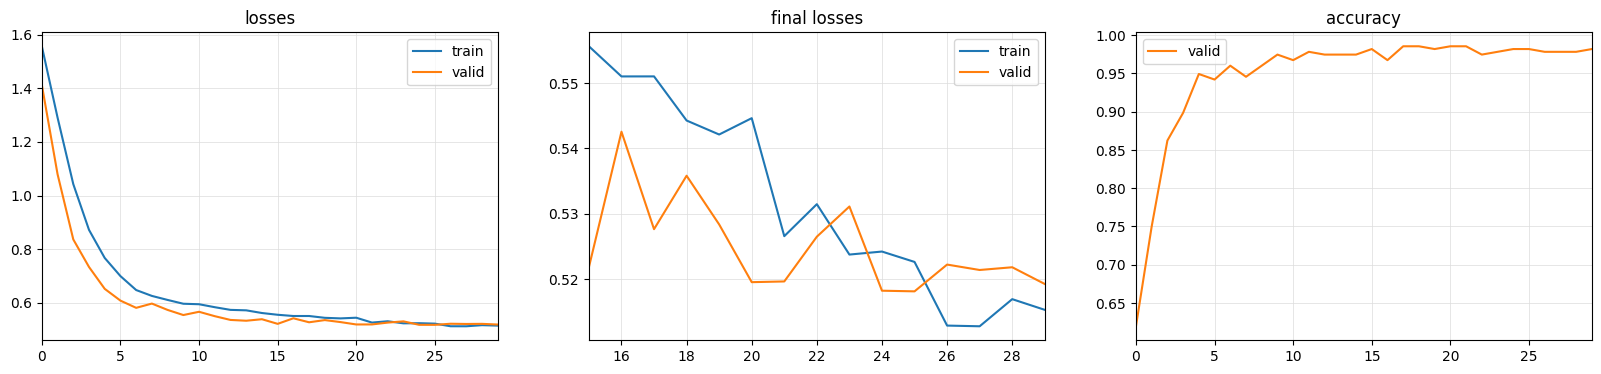


Elapsed time: 53.68328046798706


In [ ]:
model = TST(dls.vars, dls.c, dls.len, dropout=.3)
# model = TST(dls.vars, dls.c, dls.len, dropout=.1, fc_dropout=.8)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy,  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(n_epoch, lr_max=3e-4)
print('\nElapsed time:', time.time() - start)
beep()

dropout 本身可以减少过拟合，但并不能消除它.

In [ ]:
learn.save_all(path='tst_export', dls_fname='tst_30epoch_dataset_update3_dls', model_fname='tst_30epoch_dataset_update3_model',
               learner_fname='tst_30epoch_dataset_update3_learner')

In [ ]:
learn = load_learner_all(path='tst_export', dls_fname='tst_30epoch_dataset_update3_dls',
                         model_fname='tst_30epoch_dataset_update3_model', learner_fname='tst_30epoch_dataset_update3_learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[5.6240e-03, 1.4888e-02, 9.4736e-01, 1.7802e-02, 3.6784e-03, 1.0649e-02],
         [1.0971e-02, 1.4830e-02, 2.2276e-02, 9.1456e-01, 1.7681e-02, 1.9684e-02],
         [9.8010e-03, 1.5804e-02, 9.1320e-01, 3.5896e-02, 1.1198e-02, 1.4097e-02],
         ...,
         [1.9426e-03, 9.5328e-01, 2.9584e-02, 3.4691e-03, 7.7283e-03, 3.9984e-03],
         [9.1245e-03, 1.4949e-02, 3.6530e-02, 9.1539e-01, 1.4381e-02, 9.6301e-03],
         [2.4371e-03, 8.3613e-04, 7.0595e-04, 8.6059e-04, 9.9402e-01, 1.1438e-03]]),
 tensor([2, 3, 2, 1, 3, 4, 0, 5, 2, 0, 3, 2, 3, 3, 3, 4, 1, 2, 2, 1, 3, 3, 1, 2,
         1, 2, 4, 3, 2, 1, 2, 3, 3, 1, 2, 2, 5, 1, 3, 3, 2, 5, 3, 0, 5, 1, 4, 3,
         1, 0, 0, 3, 0, 2, 1, 0, 1, 5, 5, 5, 2, 4, 2, 1, 1, 3, 1, 3, 0, 0, 2, 1,
         1, 5, 1, 4, 3, 3, 1, 3, 2, 1, 5, 1, 2, 1, 0, 2, 1, 5, 5, 0, 5, 3, 5, 1,
         2, 4, 0, 4, 3, 1, 5, 5, 1, 3, 3, 2, 3, 4, 3, 1, 2, 5, 3, 0, 4, 3, 3, 2,
         3, 5, 5, 3, 3, 1, 3, 5, 3, 5, 2, 0, 3, 5, 1, 1, 2, 3, 3, 2, 3, 1, 0, 1,


In [ ]:
(valid_targets == valid_preds).float().mean()

tensor(0.9855)

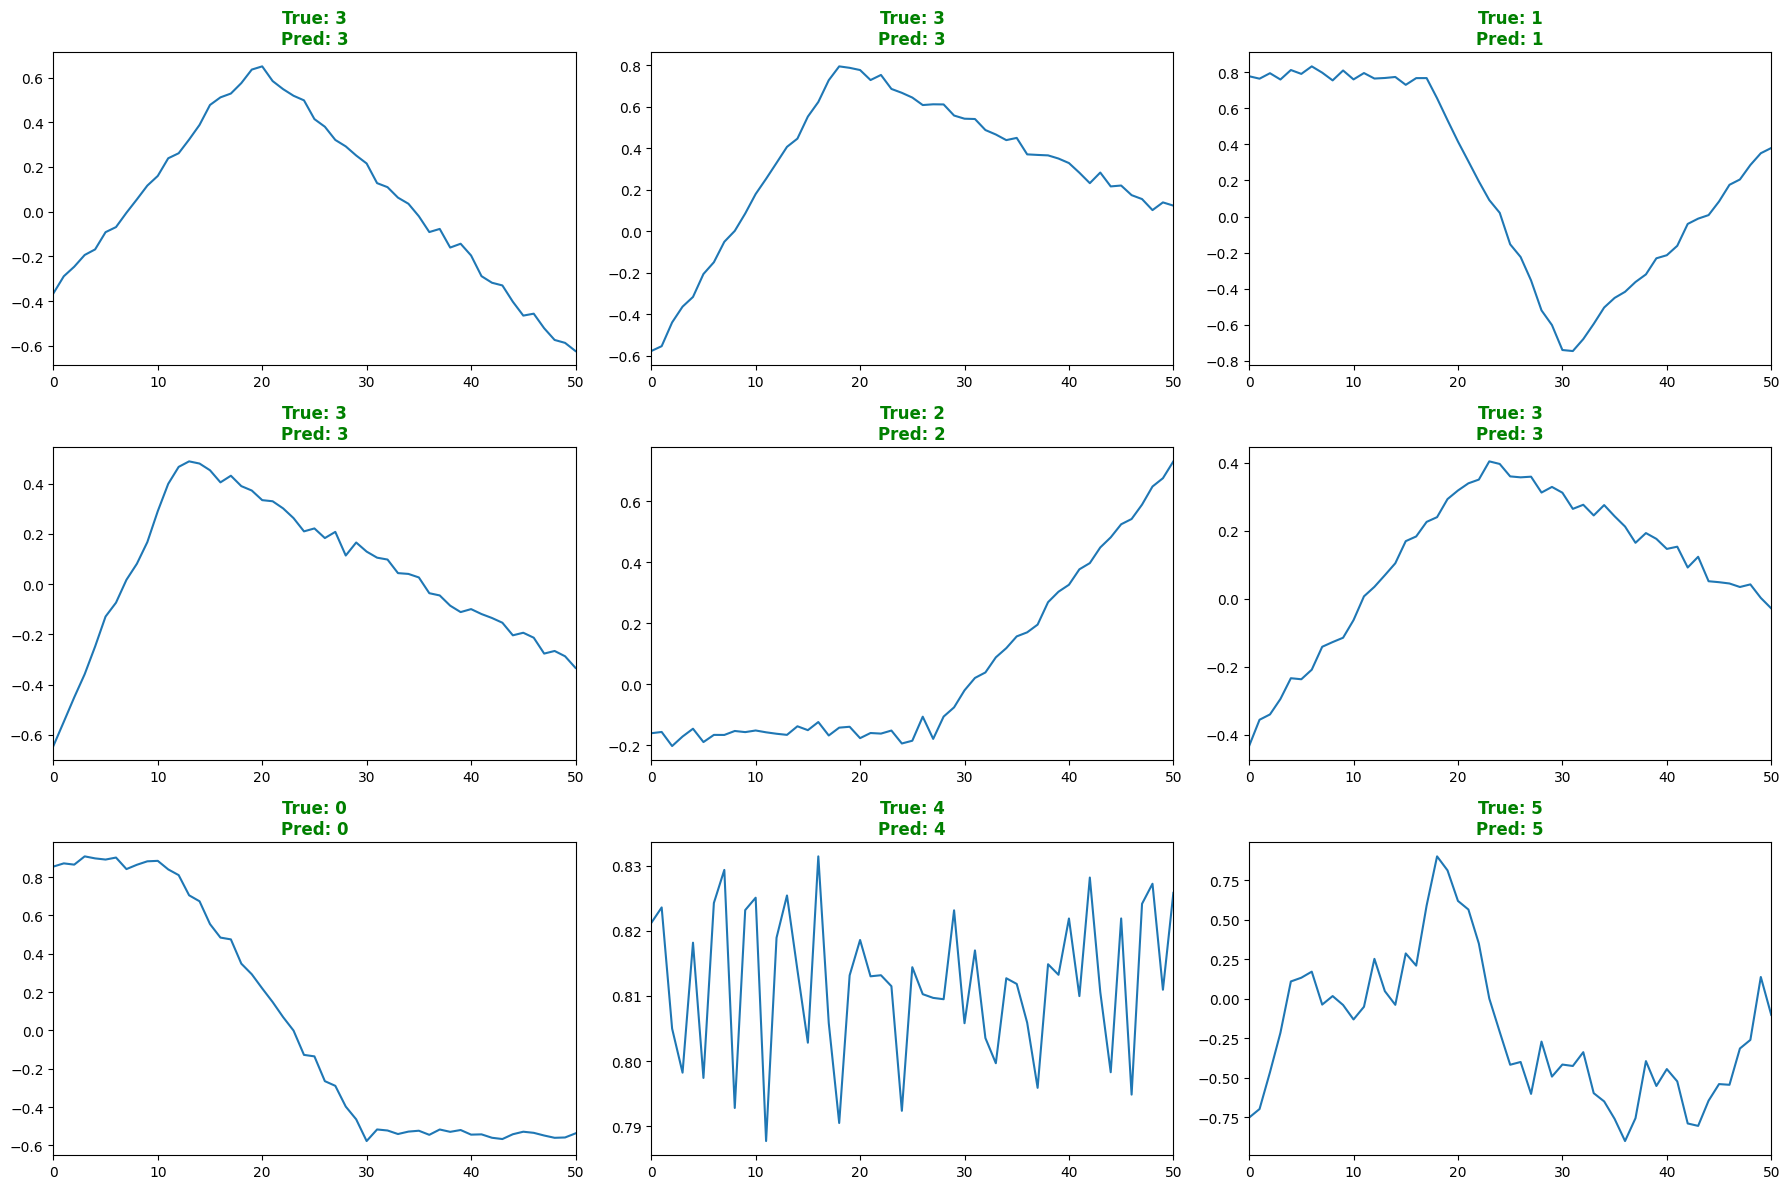

In [ ]:
learn.show_results()

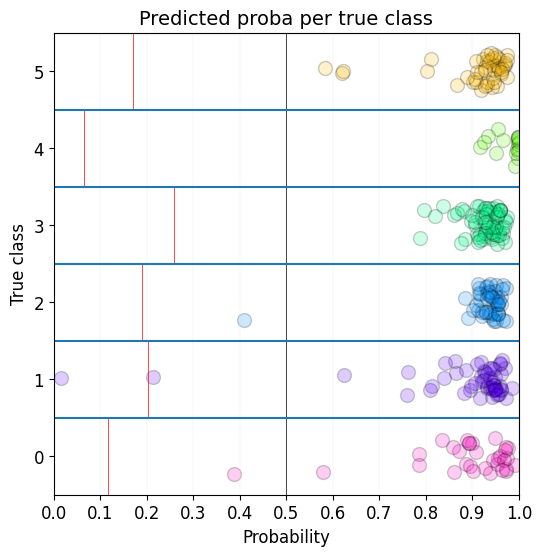

In [ ]:
learn.show_probas()

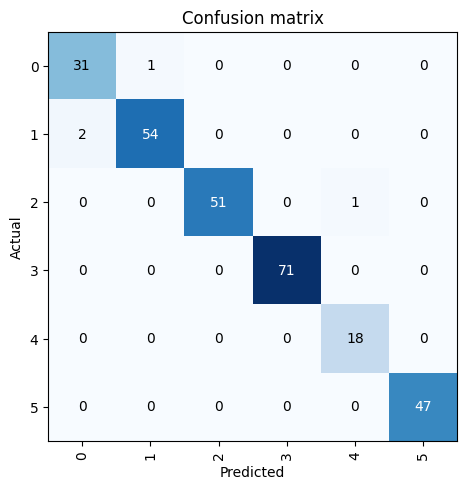

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

>**影像数据测试**

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
# Load the .tif image
with rasterio.open("/content/NDVI51years_median.tif") as src:
    image_data = src.read()
    row = image_data.shape[1]
    column = image_data.shape[2]
    # Reshape to (rows, columns, bands)
    image_data = np.transpose(image_data, (1, 2, 0))

print('transposed shape:', image_data.shape)

# Reshape the image data to (rows * columns, bands)
img_data = image_data.reshape(-1,image_data.shape[2])
print('reshaped shape:', img_data.shape)

transposed shape: (628, 620, 51)
reshaped shape: (389360, 51)


In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(ts_data)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:16, vars:1, len:51, device=cuda:0, dtype=torch.float32),)

In [ ]:
test_probas, test_targets, test_decoded = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None)
test_decoded

tensor([4, 4, 4,  ..., 4, 4, 2])

In [ ]:
classified = test_decoded.reshape(row,column)
print('classified shape:',classified.shape)
print('begin saving classified image....')
# Save the classified image
with rasterio.open('/content/slc_ndvi_tst_cls.tif', 'w', driver='GTiff',
                   height=row, width=column, count=1, dtype=rasterio.int8, crs=src.crs, transform=src.transform,
                   nodata=src.nodata, compress='lzw'
                   ) as dst:
    dst.write(classified, 1)
print('Done')

classified shape: torch.Size([628, 620])
begin saving classified image....
Done


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/dataset_update3_bkup.csv")

# 获取标签的唯一值
labels = df['label'].unique()

# 遍历每个标签
for label in labels:
    # 创建一个新的图形
    plt.figure()

    # 获取该标签的所有数据
    data = df[df['label'] == label]['dataset']

    # 将数据转换为列表
    data_list = [eval(i) for i in data]

    # 绘制数据
    for data in data_list:
        plt.plot(data, alpha=0.5)

    # 显示图形
    plt.show()

    #0下降 1下降后上升 2上升 3上升后下降 4平稳 5多次干扰

Output hidden; open in https://colab.research.google.com to view.

# Conclusion ✅

TST（时间序列变换器）似乎是时间序列模型世界的一个伟大补充。

模型训练非常顺利，并且可以通过使用 dropout 来减少/消除过度拟合。

此外，TST 的训练速度比 InceptionTime 快 10% 左右。
以下是使用“tsai”训练 Transformer 模型所需的所有代码：

```
X, y, splits = get_UCR_data('FaceDetection', return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=64, batch_tfms=TSStandardize(by_var=True))
model = TST(dls.vars, dls.c, dls.len, dropout=0.3, fc_dropout=0.9)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(),
                metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.fit_one_cycle(100, 1e-4)
```